# COMP3000HK - Computer Project
## Topic: Image spam detection using machine learning

In [1]:
# Import required libraries
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pytesseract
import matplotlib.pyplot as plt

## Part 1 - Define Functions

Define necessary functions

In [3]:
def read_text_from_image(image_path):
    # Extract text from an image using pytesseract.
    image = Image.open(image_path)
    text = pytesseract.image_to_string(image)
    return text

In [2]:
def load_dataset(csv_file, screenshots_folder):
    # Load dataset from a CSV file and extract text from images.
    df = pd.read_csv(csv_file)
    texts = []
    labels = df['label'].tolist()

    for filename in df['filename']:
        image_path = os.path.join(screenshots_folder, filename)
        text = read_text_from_image(image_path)
        texts.append(text)

    return texts, labels

In [4]:
def build_lstm_model(tokenizer, max_sequence_length, lstm_layer_size):
    # Build an LSTM model with a specified layer size.
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(len(tokenizer.word_index) + 1, 128, input_length=max_sequence_length),
        tf.keras.layers.SpatialDropout1D(0.2),
        tf.keras.layers.LSTM(lstm_layer_size, dropout=0.2, recurrent_dropout=0.2),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

In [5]:
def preprocess_text(text, tokenizer, max_sequence_length):
    # Preprocess text by tokenizing and padding sequences.
    tokenized_text = tokenizer.texts_to_sequences([text])
    padded_text = tf.keras.preprocessing.sequence.pad_sequences(tokenized_text, maxlen=max_sequence_length)
    return padded_text

In [23]:
# Plot training results using matplotlib
def plot_loss(history):
    # Plot the training and validation accuracy and loss.
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    # Plot the loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [25]:
# Plot training results using matplotlib
def plot_accuracy(history):
    # Plot the training and validation accuracy and loss.
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    # Plot the accuracy
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

## Part 2 - Data Preprocessing

### Importing the dataset

In [7]:
# Load the dataset
csv_file = "email_dataset.csv"
screenshots_folder = "/Users/ivan/Code/comp3000hk-computer-project/selenium"
emails, labels = load_dataset(csv_file, screenshots_folder)



### Splitting the dataset into the Training set and Test set

In [8]:
# Encode the labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Train-test split
emails_train, emails_test, labels_train, labels_test = train_test_split(emails, labels_encoded, test_size=0.2, random_state=42)


In [9]:
# Tokenize and pad the text
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(emails_train)
max_sequence_length = 250
batch_size = 32

train_sequences = tokenizer.texts_to_sequences(emails_train)
test_sequences = tokenizer.texts_to_sequences(emails_test)

train_padded = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=max_sequence_length)
test_padded = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=max_sequence_length)

# Create datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_padded, labels_train)).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((test_padded, labels_test)).batch(batch_size)


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



## Part 3 - Building and Training the LSTM Mdoel

In [10]:
# Build the LSTM model
lstm_layer_size = 64
model = build_lstm_model(tokenizer, max_sequence_length, lstm_layer_size)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()



Epoch 1/6


2023-05-07 23:03:47.547664: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


3/3 [==============================] - 426s 142s/step - loss: 0.6869 - accuracy: 0.6400 - val_loss: 0.6673 - val_accuracy: 0.8947
Epoch 2/6
3/3 [==============================] - 404s 132s/step - loss: 0.6553 - accuracy: 0.8400 - val_loss: 0.6384 - val_accuracy: 0.8947
Epoch 3/6
3/3 [==============================] - 474s 158s/step - loss: 0.6121 - accuracy: 0.8800 - val_loss: 0.5925 - val_accuracy: 0.8947
Epoch 4/6
3/3 [==============================] - 460s 155s/step - loss: 0.5419 - accuracy: 0.9200 - val_loss: 0.5082 - val_accuracy: 0.8947
Epoch 5/6
3/3 [==============================] - 465s 155s/step - loss: 0.4192 - accuracy: 0.9333 - val_loss: 0.3520 - val_accuracy: 0.7895
Epoch 6/6
3/3 [==============================] - 463s 155s/step - loss: 0.2853 - accuracy: 0.8800 - val_loss: 0.3012 - val_accuracy: 0.7895


In [ ]:
# Train the model
history = model.fit(train_dataset, epochs=6, validation_data=test_dataset)

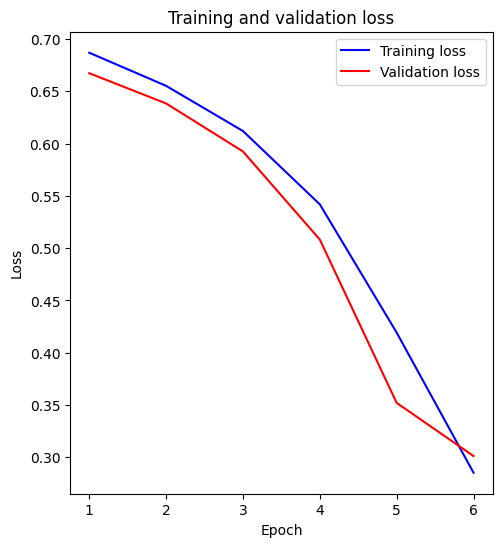

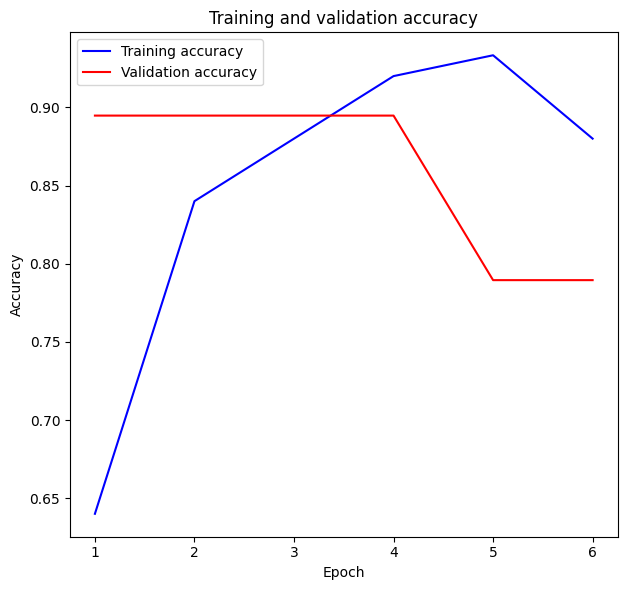

In [26]:
# Plot the training history
plot_loss(history)
plot_accuracy(history)

### Predict the result of the test image

In [16]:
# Test with a sample email
sample_image_path = "testing_images/image.png"
sample_email_text = read_text_from_image(sample_image_path)
preprocessed_text = preprocess_text(sample_email_text, tokenizer, max_sequence_length)
prediction = model.predict(preprocessed_text)
predicted_label = np.argmax(prediction)

1/1 [==============================] - 2s 2s/step


In [17]:
print("Prediction:", "spam" if predicted_label == 1 else "ham")

Prediction: ham
